# AdaBoost

### Fit

1. Initialize weight for each sample $w_0 = \frac{1}{N}$
2. Train $n$ classifiers

### Training
1. Initialize weak classifier (decision stump)
2. Using greedy search loop over all features and threshold
3. Calculate the error $\epsilon$ = sum of weights associated with each misclassified sample for each (feature, threshold) pair
4. If $\epsilon \geq 0.5$, flip $\epsilon$ to $1 - \epsilon$ and polarity to -1
5. When the smallest $\epsilon$ is obtained store the current polarity, feature and threshold 
6. After greedy search calculate $\alpha = 0.5 \log \left( \frac{1 - \epsilon}{\epsilon} \right)$
7. Update weights $\mathbf{w_{n + 1}} = \mathbf{w_{n}} \cdot \exp(- \alpha \cdot h(\mathbf{X}))$
8. Normalize weights $\mathbf{w_{n + 1}} = \frac{\mathbf{w_{n + 1}}}{\sum w}$

### Predict
1. Calculate $ \text{sgn} \left( \sum_{i}^{n} \alpha_i \cdot h_i(\mathbf{X}) \right)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [4]:
class DecisionStump:
    
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)

        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions
    
class AdaBoost:

    def __init__(self, n_classifiers=5):
        self.n_classifiers = n_classifiers

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights
        w = np.ones(n_samples) / n_samples

        self.classifiers = []

        # Train n classifiers
        for _ in range(self.n_classifiers):

            # Create weak classifier
            clf = DecisionStump()

            min_error = float('inf')

            # Loop over all features and thresholds
            for feature_index in range(n_features):

                X_column = X[:, feature_index]
                thresholds = np.unique(X_column)

                for threshold in thresholds:

                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    if error < min_error:
                        min_error = error
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_index
            
            clf.alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

            predictions = clf.predict(X)

            # Update weights
            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize weights
            w /= sum(w)

            self.classifiers.append(clf)

    def predict(self, X):
        return np.sign(np.sum([clf.alpha * clf.predict(X) for clf in self.classifiers], axis=0))


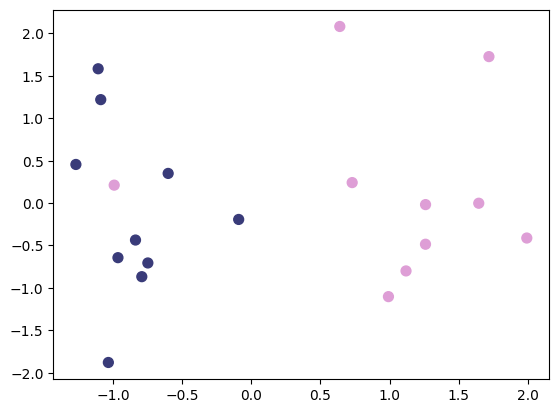

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=20, n_features=2, n_classes=2, n_informative=2, n_redundant=0)
y = np.where(y != 1, -1, 1)
plot_2d_clf_problem(X, y)

Accuracy: 0.95


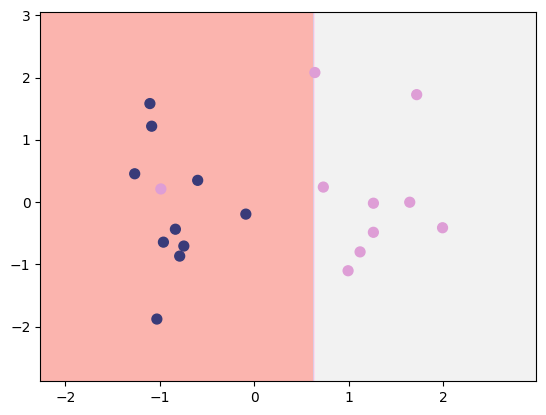

In [7]:
model = AdaBoost()
model.fit(X, y)
y_pred = model.predict(X)
print(f'Accuracy: {np.mean(y_pred == y)}')
plot_2d_clf_problem(X, y, model.predict)
plt.show()